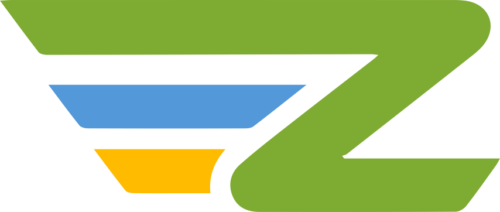

## Zembo Data Science Assessment

## Overview
This project analyzes IoT battery charge and swap data to extract insights, build predictive models, and detect anomalies to optimize battery maintenance and improve operational efficiency.





For any queries, feel free to reach out!

**Email**: allanmutethiah@gmail.com

**Cell**: +254 790 429 988

# 📌 Importing Necessary Libraries
# These libraries are essential for data analysis, visualization, and machine learning.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler


# 📌 Mount Google Drive
Since our dataset is stored in Google Drive, we need to mount it in Colab

This allows us to access and read files stored in Google Drive.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
battery_data = pd.read_csv("/content/drive/MyDrive/IoT_Battery_Analysis/data/battery_data.csv", parse_dates=['_time'])

SWAP_IN_PATH = "/content/drive/MyDrive/IoT_Battery_Analysis/data/swap_in_data.csv"
SWAP_OUT_PATH = "/content/drive/MyDrive/IoT_Battery_Analysis/data/swap_out_data.csv"

Mounted at /content/drive


### 📌 Load Swap Data

Reads battery swap-in and swap-out event records from CSV files.

`parse_dates` ensures that date columns are treated as datetime objects for time-series analysis.


In [ ]:
# **Load swap data**
swap_in_data = pd.read_csv(SWAP_IN_PATH, parse_dates=["swap_in_date"])
swap_out_data = pd.read_csv(SWAP_OUT_PATH, parse_dates=["swap_out_date"])


### 📌 Convert Timestamps to Datetime Format

Ensures that the swap-in and swap-out dates are properly formatted as datetime objects.

`errors='coerce'` converts any invalid date values into NaT (Not a Time) instead of causing errors.


In [ ]:
# **Convert timestamps to datetime format**
swap_in_data['swap_in_date'] = pd.to_datetime(swap_in_data['swap_in_date'], errors='coerce')
swap_out_data['swap_out_date'] = pd.to_datetime(swap_out_data['swap_out_date'], errors='coerce')

### 📌 Aggregate Swap-In and Swap-Out Data Per Day

This step summarizes swap events by counting the number of swaps per day.

In [ ]:
# **Aggregate swap in and swap out data per day**
swap_in_data['swap_in_count'] = 1
swap_out_data['swap_out_count'] = 1
swap_in_summary = swap_in_data.groupby(swap_in_data['swap_in_date'].dt.date).agg({'swap_in_count': 'sum'}).reset_index()
swap_out_summary = swap_out_data.groupby(swap_out_data['swap_out_date'].dt.date).agg({'swap_out_count': 'sum'}).reset_index() # Changed 'swap_in_date' to 'swap_out_date'

### 📌 Merge Swap Data into Battery Data

This step integrates the daily swap-in and swap-out counts with the battery dataset.


In [ ]:
# **Merge Swap Data into Battery Data**
# Convert '_time' to datetime.date in all DataFrames before merging
# Ensure '_time' is in datetime format before applying .dt
battery_data['_time'] = pd.to_datetime(battery_data['_time']).dt.date  # Convert to datetime.date
swap_in_summary['_time'] = pd.to_datetime(swap_in_summary['swap_in_date']).dt.date
swap_out_summary['_time'] = pd.to_datetime(swap_out_summary['swap_out_date']).dt.date

# Check if 'swap_in_count' or 'swap_out_count' already exist in battery_data
# If they do, drop them before merging to avoid duplicate columns
if 'swap_in_count' in battery_data.columns:
    battery_data = battery_data.drop(columns=['swap_in_count'])
if 'swap_out_count' in battery_data.columns:
    battery_data = battery_data.drop(columns=['swap_out_count'])

battery_data = battery_data.merge(swap_in_summary, on='_time', how='left')
battery_data = battery_data.merge(swap_out_summary, on='_time', how='left')


In [ ]:
# **Check if the Fix Worked**
print(battery_data[['swap_in_count', 'swap_out_count']].describe())

       swap_in_count  swap_out_count
count   24865.000000    24865.000000
mean      743.739473      743.755158
std       229.183696      229.147985
min       221.000000      223.000000
25%       553.000000      553.000000
50%       735.000000      735.000000
75%      1002.000000     1002.000000
max      1165.000000     1165.000000


In [ ]:
# **Select Features for EDA**
eda_features = ["SOC", "Total_voltage", "Internal_temperature_of_battery", "Number_of_cycles", "swap_in_count", "swap_out_count"]


# ------------------------------ 🔍 **Univariate Analysis** ------------------------------


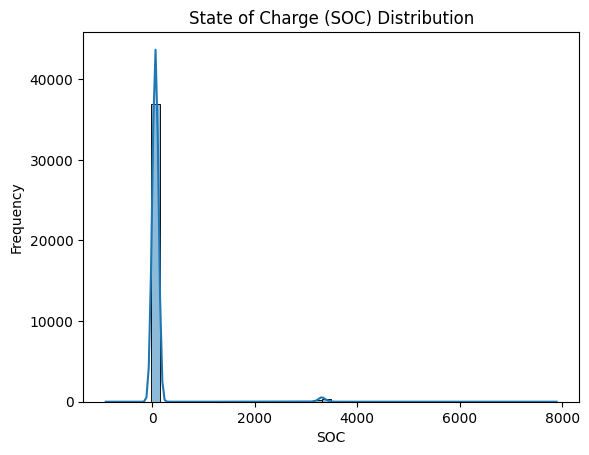

In [ ]:
# **1️⃣ Distribution of SOC**
sns.histplot(battery_data['SOC'].dropna(), bins=50, kde=True)
plt.title("State of Charge (SOC) Distribution")
plt.xlabel("SOC")
plt.ylabel("Frequency")
plt.show()

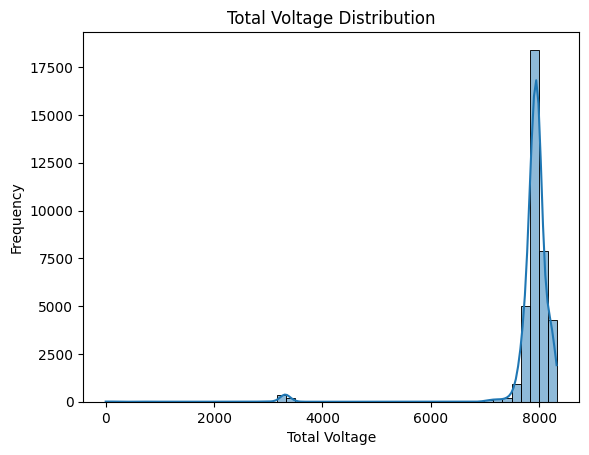

In [ ]:
# **2️⃣ Distribution of Total Voltage**
sns.histplot(battery_data['Total_voltage'].dropna(), bins=50, kde=True)
plt.title("Total Voltage Distribution")
plt.xlabel("Total Voltage")
plt.ylabel("Frequency")
plt.show()

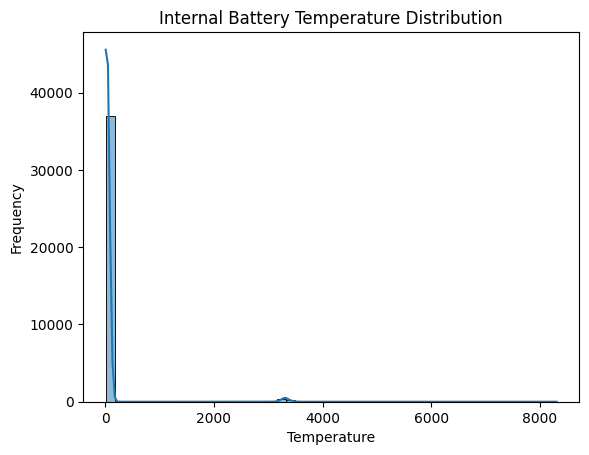

In [ ]:
# **3️⃣ Distribution of Internal Battery Temperature**
sns.histplot(battery_data['Internal_temperature_of_battery'].dropna(), bins=50, kde=True)
plt.title("Internal Battery Temperature Distribution")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

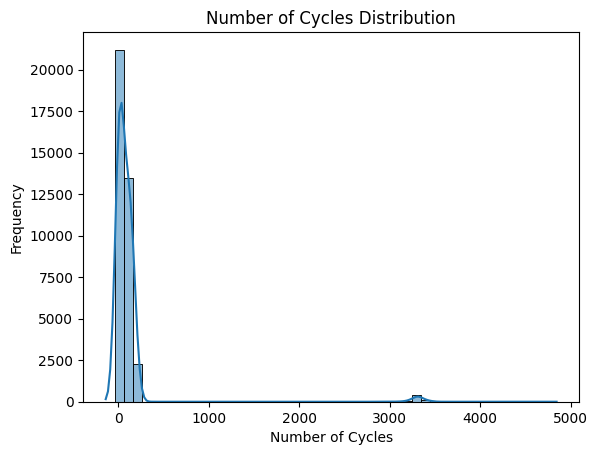

In [ ]:
# **4️⃣ Distribution of Number of Cycles**
sns.histplot(battery_data['Number_of_cycles'].dropna(), bins=50, kde=True)
plt.title("Number of Cycles Distribution")
plt.xlabel("Number of Cycles")
plt.ylabel("Frequency")
plt.show()

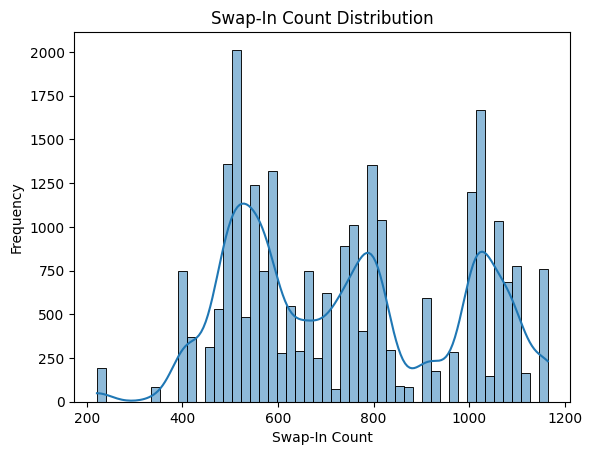

In [ ]:
# **5️⃣ Distribution of Swap-In Count**
sns.histplot(battery_data['swap_in_count'].dropna(), bins=50, kde=True)
plt.title("Swap-In Count Distribution")
plt.xlabel("Swap-In Count")
plt.ylabel("Frequency")
plt.show()


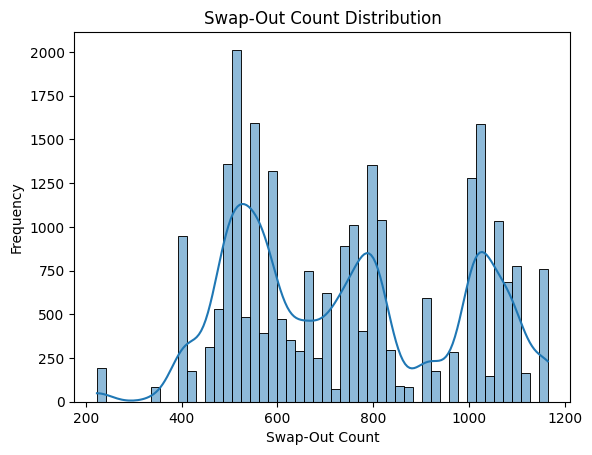

In [ ]:
# **6️⃣ Distribution of Swap-Out Count**
sns.histplot(battery_data['swap_out_count'].dropna(), bins=50, kde=True)
plt.title("Swap-Out Count Distribution")
plt.xlabel("Swap-Out Count")
plt.ylabel("Frequency")
plt.show()

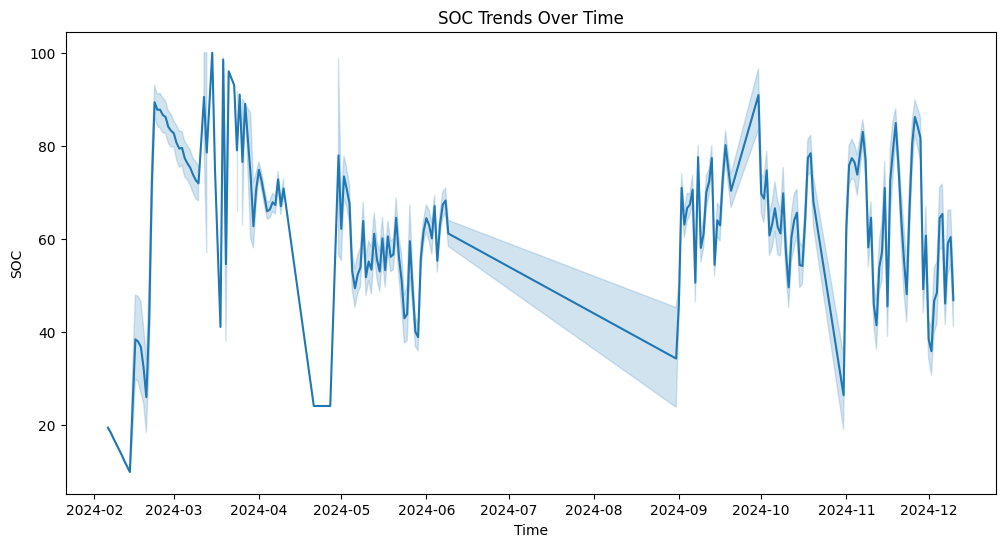

In [ ]:
# **7️⃣ SOC Over Time**
plt.figure(figsize=(12, 6))
sns.lineplot(data=battery_data, x='_time', y='SOC')
plt.title("SOC Trends Over Time")
plt.xlabel("Time")
plt.ylabel("SOC")
plt.show()

# ------------------------------ 📊 **Bivariate Analysis** ------------------------------


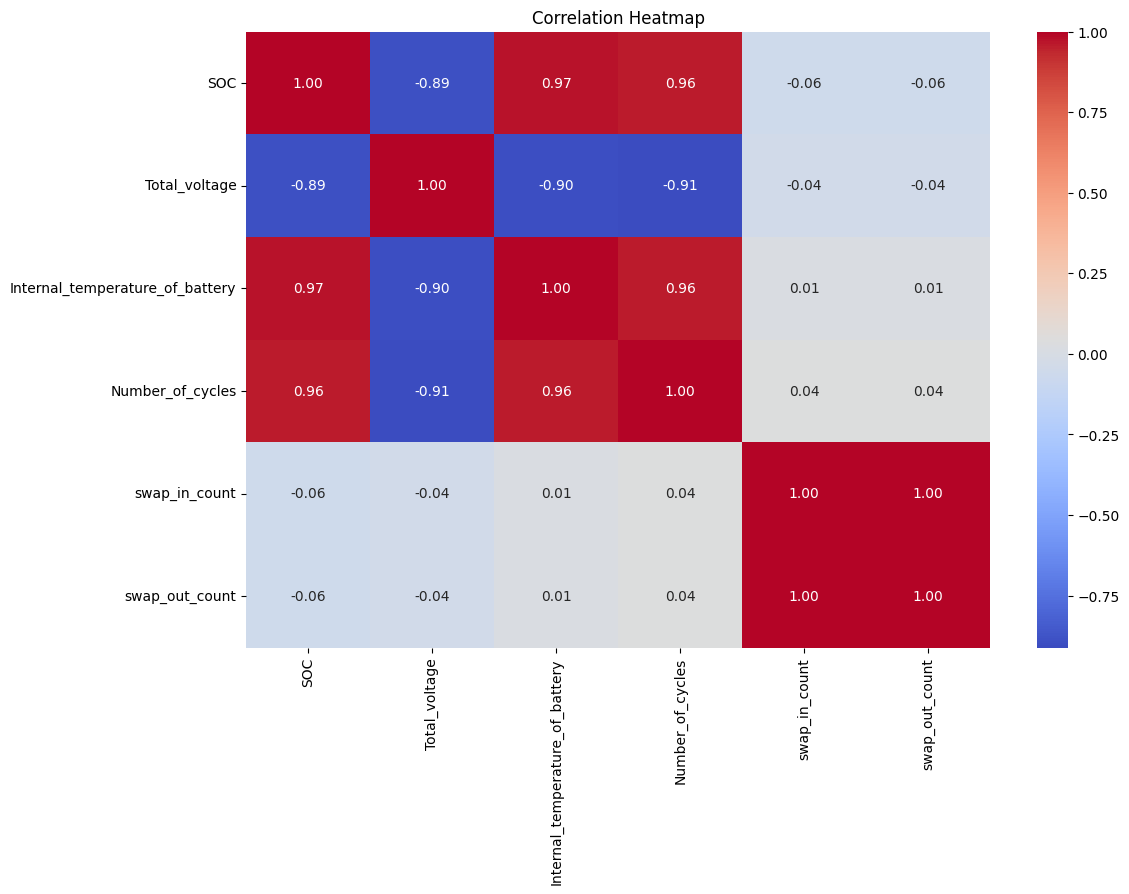

In [ ]:

# **8️⃣ Correlation Heatmap**
plt.figure(figsize=(12, 8))
sns.heatmap(battery_data[eda_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

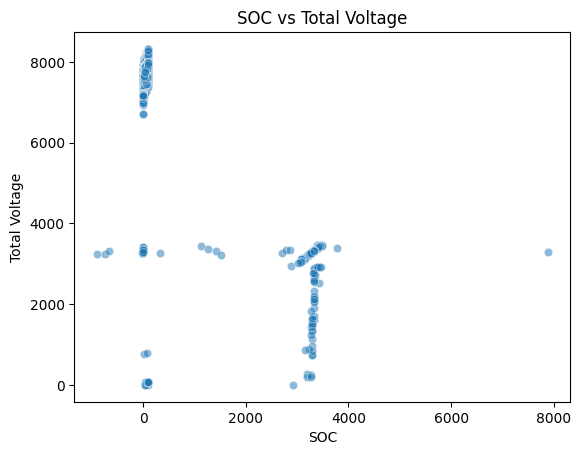

In [ ]:
# **9️⃣ SOC vs Total Voltage**
sns.scatterplot(data=battery_data, x='SOC', y='Total_voltage', alpha=0.5)
plt.title("SOC vs Total Voltage")
plt.xlabel("SOC")
plt.ylabel("Total Voltage")
plt.show()

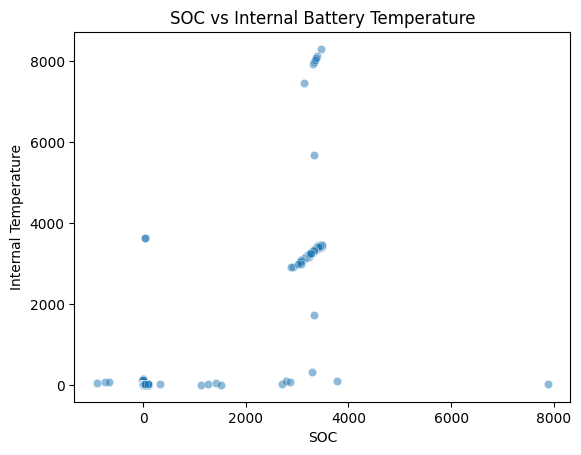

In [ ]:
# **🔟 SOC vs Internal Battery Temperature**
sns.scatterplot(data=battery_data, x='SOC', y='Internal_temperature_of_battery', alpha=0.5)
plt.title("SOC vs Internal Battery Temperature")
plt.xlabel("SOC")
plt.ylabel("Internal Temperature")
plt.show()

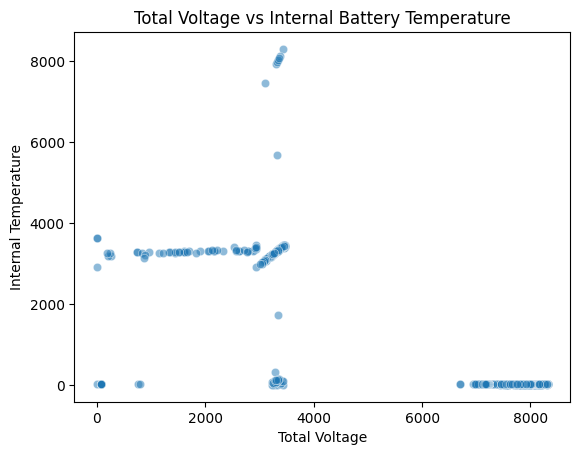

In [ ]:
# **1️⃣1️⃣ Total Voltage vs Internal Battery Temperature**
sns.scatterplot(data=battery_data, x='Total_voltage', y='Internal_temperature_of_battery', alpha=0.5)
plt.title("Total Voltage vs Internal Battery Temperature")
plt.xlabel("Total Voltage")
plt.ylabel("Internal Temperature")
plt.show()

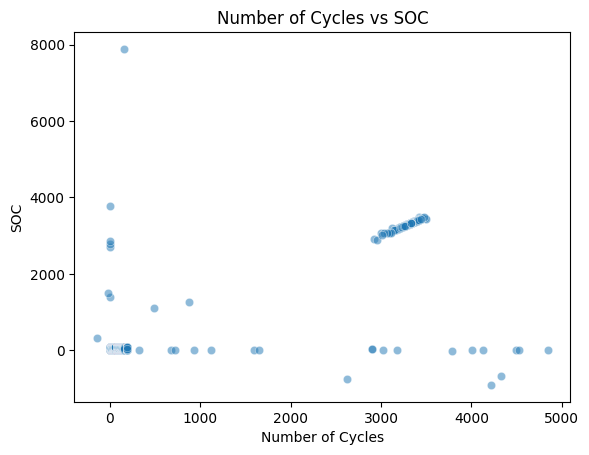

In [ ]:
# **1️⃣2️⃣ Number of Cycles vs SOC**
sns.scatterplot(data=battery_data, x='Number_of_cycles', y='SOC', alpha=0.5)
plt.title("Number of Cycles vs SOC")
plt.xlabel("Number of Cycles")
plt.ylabel("SOC")
plt.show()

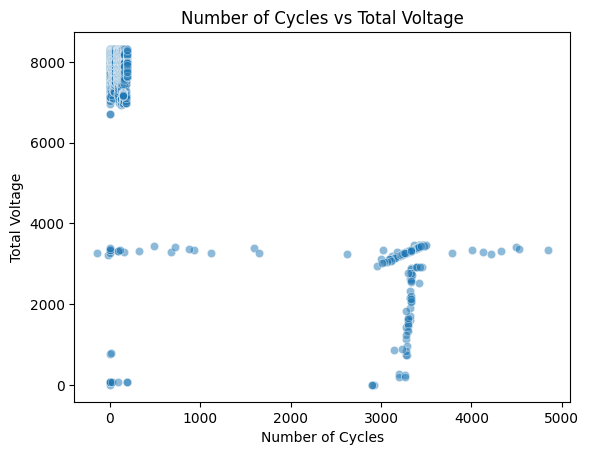

In [ ]:
# **1️⃣3️⃣ Number of Cycles vs Total Voltage**
sns.scatterplot(data=battery_data, x='Number_of_cycles', y='Total_voltage', alpha=0.5)
plt.title("Number of Cycles vs Total Voltage")
plt.xlabel("Number of Cycles")
plt.ylabel("Total Voltage")
plt.show()


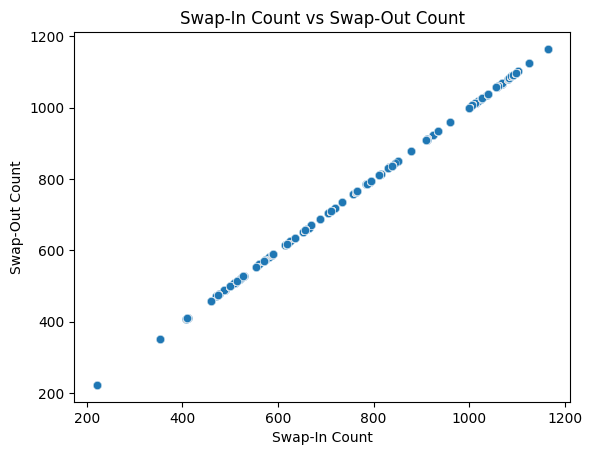

In [ ]:
# **1️⃣4️⃣ Swap-In Count vs Swap-Out Count**
sns.scatterplot(data=battery_data, x='swap_in_count', y='swap_out_count', alpha=0.5)
plt.title("Swap-In Count vs Swap-Out Count")
plt.xlabel("Swap-In Count")
plt.ylabel("Swap-Out Count")
plt.show()

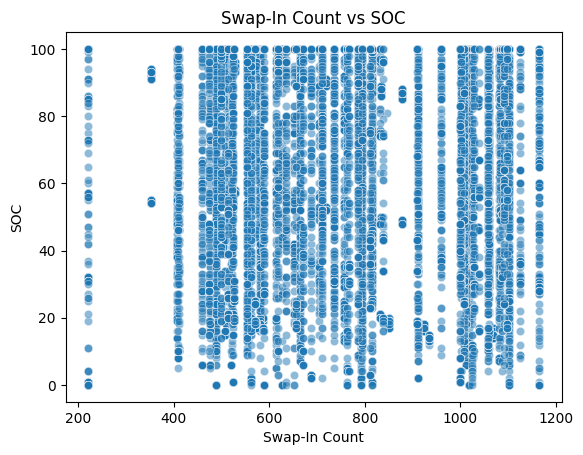

In [ ]:

# **1️⃣5️⃣ Swap-In Count vs SOC**
sns.scatterplot(data=battery_data, x='swap_in_count', y='SOC', alpha=0.5)
plt.title("Swap-In Count vs SOC")
plt.xlabel("Swap-In Count")
plt.ylabel("SOC")
plt.show()

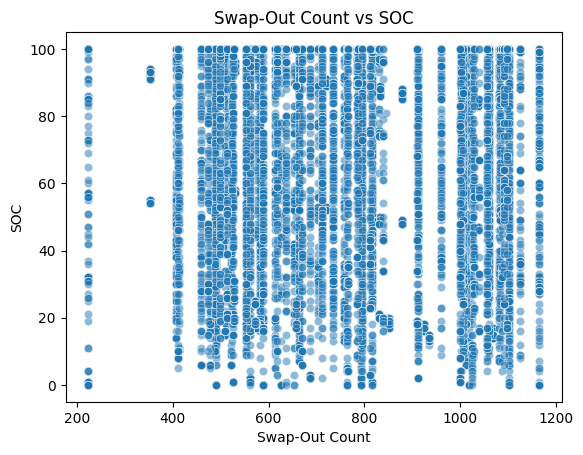

In [ ]:
# **1️⃣6️⃣ Swap-Out Count vs SOC**
sns.scatterplot(data=battery_data, x='swap_out_count', y='SOC', alpha=0.5)
plt.title("Swap-Out Count vs SOC")
plt.xlabel("Swap-Out Count")
plt.ylabel("SOC")
plt.show()

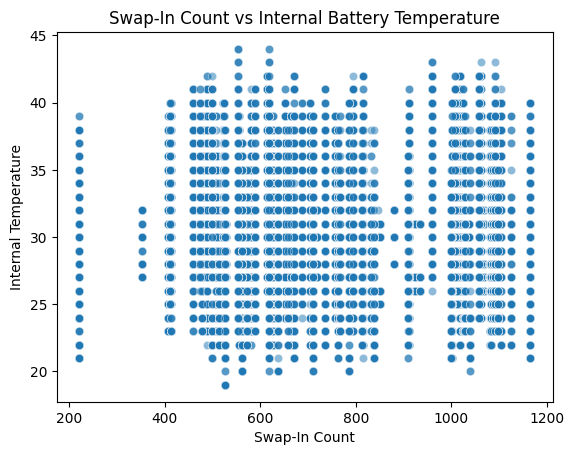

In [ ]:
# **1️⃣7️⃣ Swap-In Count vs Internal Battery Temperature**
sns.scatterplot(data=battery_data, x='swap_in_count', y='Internal_temperature_of_battery', alpha=0.5)
plt.title("Swap-In Count vs Internal Battery Temperature")
plt.xlabel("Swap-In Count")
plt.ylabel("Internal Temperature")
plt.show()

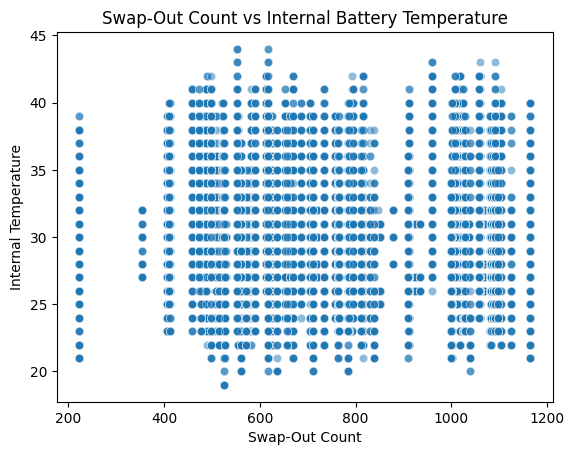

In [ ]:
# **1️⃣8️⃣ Swap-Out Count vs Internal Battery Temperature**
sns.scatterplot(data=battery_data, x='swap_out_count', y='Internal_temperature_of_battery', alpha=0.5)
plt.title("Swap-Out Count vs Internal Battery Temperature")
plt.xlabel("Swap-Out Count")
plt.ylabel("Internal Temperature")
plt.show()

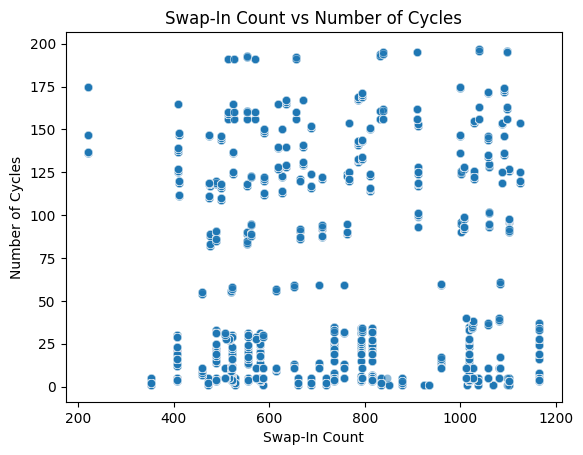

In [ ]:
# **1️⃣9️⃣ Swap-In Count vs Number of Cycles**
sns.scatterplot(data=battery_data, x='swap_in_count', y='Number_of_cycles', alpha=0.5)
plt.title("Swap-In Count vs Number of Cycles")
plt.xlabel("Swap-In Count")
plt.ylabel("Number of Cycles")
plt.show()

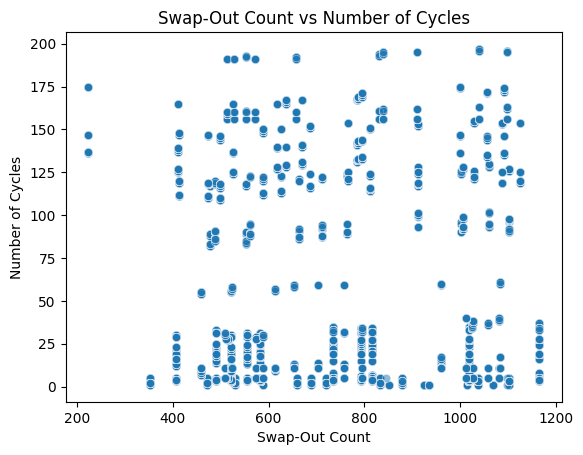

In [ ]:
# **2️⃣0️⃣ Swap-Out Count vs Number of Cycles**
sns.scatterplot(data=battery_data, x='swap_out_count', y='Number_of_cycles', alpha=0.5)
plt.title("Swap-Out Count vs Number of Cycles")
plt.xlabel("Swap-Out Count")
plt.ylabel("Number of Cycles")
plt.show()

#  **Proceed with Forecasting Only if We Have Non-Zero Data**

### **1️⃣ Check if Swap Data Exists**
- Ensures the forecasting model only runs if we have **non-zero swap-in and swap-out data**.
- Prevents unnecessary computation and avoids errors from an **empty dataset**.

### **2️⃣ Resample Data to Daily Level**
- Converts `_time` column into **datetime format** for accurate time-series analysis.
- Uses **daily resampling** to standardize the dataset, ensuring consistency.
- Selects only **numeric features**, ignoring text/categorical data.
- Aggregates values using **mean**, making the dataset ready for forecasting.

### **3️⃣ Select Features for Forecasting**
- Defines **input features** that influence battery swaps, including:
  - **SOC (State of Charge)** – Tracks battery depletion.
  - **Total Voltage** – Indicates battery health.
  - **Internal Temperature** – Helps detect overheating issues.
  - **Number of Cycles** – Shows battery aging over time.
- Defines **target variables**:
  - `swap_in_count` – Number of batteries swapped in per day.
  - `swap_out_count` – Number of batteries swapped out per day.

### **4️⃣ Handle Missing Data**
- **Fills NaN values** using **sum or median**:
  - Uses **sum** if it makes sense for the feature (e.g., cycle count).
  - Uses **median** as a fallback to avoid distorting data.
- Ensures that missing values **do not affect model performance**.
- Prepares the dataset for **smooth machine learning model training**.

---
✅ **Why is this important?**
- Ensures **clean, structured, and well-prepared** data before forecasting.
- Converts raw IoT battery data into a **time-series format**.
- Handles **missing values efficiently** to prevent errors in modeling.
- Enables **accurate and reliable battery swap predictions**.



In [ ]:
# **Proceed with Forecasting Only if We Have Non-Zero Data**
if battery_data['swap_in_count'].sum() > 0 and battery_data['swap_out_count'].sum() > 0:

    # **Resample Data to Daily Level**
    # Ensure '_time' is a DatetimeIndex
    battery_data['_time'] = pd.to_datetime(battery_data['_time'])  # Convert to datetime objects
    # Only include numeric features in the resampling
    numeric_features = battery_data.select_dtypes(include=np.number).columns.tolist()
    battery_data = battery_data.set_index('_time')[numeric_features].resample('D').mean().reset_index()

    # **Select Features for Forecasting Swap Count**
    features = ["SOC", "Total_voltage", "Internal_temperature_of_battery", "Number_of_cycles"]
    target_in = "swap_in_count"
    target_out = "swap_out_count"

    # **Fill NaN values with sum or median**
    for col in features:
        if battery_data[col].isna().sum() > 0:
            battery_data[col] = battery_data[col].fillna(battery_data[col].sum() if battery_data[col].sum() > 0 else battery_data[col].median())

# 📌 Normalize Data for Better Learning

### **Why Normalize?**
- Features like **SOC, Total Voltage, Internal Temperature, and Number of Cycles** have different scales.
- Some values (e.g., voltage) may be **much larger** than others (e.g., SOC percentage).
- Scaling ensures **all features contribute equally** to the model.

### **How MinMaxScaler Works**
- **Rescales all feature values** to a range between **0 and 1**.
- **Formula:**  
  \[
  X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
  \]
- Ensures no feature **dominates others** due to a larger numerical range.

### **Key Benefits**
✅ **Speeds up model convergence** – Helps models learn patterns faster.  
✅ **Prevents bias** – Ensures equal weight for all features.  
✅ **Reduces impact of outliers** – Normalization prevents extreme values from distorting predictions.  



In [ ]:
# Normalize Features
scaler = MinMaxScaler()
battery_data[features] = scaler.fit_transform(battery_data[features])

# 📌 Create Time Lags (Past Data as Features)

### **Why Create Time Lags?**
- Time-series models need **historical data** to make accurate predictions.
- Instead of predicting based only on the **current day's data**, we provide information from the **past 7 days**.
- This helps the model **capture trends and seasonal patterns** in swap-in and swap-out counts.

### **How Time Lags Work**
- **Shifts data** backward by `lag` days for both `swap_in_count` and `swap_out_count`.
- Example:
  - `swap_in_count_lag1` → Swap-in count from **1 day ago**.
  - `swap_in_count_lag2` → Swap-in count from **2 days ago**.
  - `swap_out_count_lag7` → Swap-out count from **7 days ago**.
- These new lagged features act as **predictors** for future values.





In [ ]:
# **Create Time Lags (Past Data as Features)**
for lag in range(1, 8):  # Past 7 days as features
        for col in [target_in, target_out]:
            battery_data[f"{col}_lag{lag}"] = battery_data[col].shift(lag)

# 📌 Fill NaN Values in Lag Features with Sum or Median

### **Why Handle Missing Values?**
- Creating **lag features** introduces **NaN values** at the beginning of the dataset.
- Example:  
  - `swap_in_count_lag1` cannot exist for the **first recorded day** since there is no previous data.
- These missing values must be **filled** to avoid issues during model training.

### **How Missing Values Are Filled**
- **If the column’s sum is greater than 0** → Fill NaNs with the **sum** of the column.
- **Else, use the median** → Avoids inflating values if the sum is 0.
- This ensures that each lagged feature has a **meaningful replacement** instead of being completely removed.





In [ ]:
 # **Fill NaN values in lag features with sum or median**
for col in battery_data.columns:
        if battery_data[col].isna().sum() > 0:
            battery_data[col] = battery_data[col].fillna(battery_data[col].sum() if battery_data[col].sum() > 0 else battery_data[col].median())


# 📌 Train-Test Split (80% Training, 20% Testing)

### **Why Split the Data?**
- We need to **train the model on historical data** and **evaluate it on unseen data**.
- This ensures the model generalizes well and does not just memorize past values.

### **How the Data is Split**
1. **`X_in` (Features)** – Contains all input features **excluding the target variables (`swap_in_count`, `swap_out_count`) and `_time`**.
2. **`y_in` (Target Variable)** – Contains the values of `swap_in_count` (number of swaps in per day).
3. **`train_test_split()`** – Splits the data:
   - **80% Training Data** – Used to train the model.
   - **20% Testing Data** – Used to evaluate performance on unseen data.
4. **`shuffle=False`** – Ensures the **chronological order** of the time-series is preserved.


In [ ]:
# Train-Test Split (Chronological)
X = battery_data.drop(columns=[target_in, target_out, '_time'], errors='ignore')
y_in = battery_data[target_in]
y_out = battery_data[target_out]

In [ ]:
X_train_in, X_test_in, y_train_in, y_test_in = train_test_split(X, y_in, test_size=0.2, shuffle=False)
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X, y_out, test_size=0.2, shuffle=False)

# 📌 Train XGBoost Model for Swap-In Prediction

### **Why Use XGBoost?**
- **XGBoost (Extreme Gradient Boosting)** is a powerful machine learning algorithm designed for:
  - Handling large datasets efficiently.
  - Capturing complex patterns in data.
  - Preventing overfitting using built-in regularization.
- It is well-suited for **time-series forecasting**, especially when feature engineering is involved.

### **How the Model is Configured**
1. **`objective='reg:squarederror'`** – Uses regression since we are predicting a continuous variable (`swap_in_count`).
2. **`n_estimators=100`** – Trains the model using 100 decision trees (boosted sequentially).
3. **`learning_rate=0.1`** – Controls how much each tree contributes to the final prediction.
4. **`fit(X_train_in, y_train_in)`** – Trains the model using the training data for **swap-in count prediction**.


In [ ]:
# Train XGBoost Models
xgb_model_in = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, subsample=0.8)
xgb_model_out = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, subsample=0.8)


In [ ]:
xgb_model_in.fit(X_train_in, y_train_in)
xgb_model_out.fit(X_train_out, y_train_out)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# 📌 Make Predictions Using XGBoost Models

### **Why Make Predictions?**
- After training the **XGBoost models**, we now use them to predict **future swap-in and swap-out counts**.
- The goal is to evaluate how well the model can **forecast unseen data** from the test set.

### **How Predictions Work**
1. **`xgb_model_in.predict(X_test_in)`**  
   - Uses the trained model for **swap-in count** prediction.
   - Inputs: `X_test_in` (features from the test set).
   - Output: `y_pred_in` (predicted number of swap-ins per day).

2. **`xgb_model_out.predict(X_test_out)`**  
   - Uses the trained model for **swap-out count** prediction.
   - Inputs: `X_test_out` (features from the test set).
   - Output: `y_pred_out` (predicted number of swap-outs per day).
.


In [ ]:
# Make Predictions
y_pred_in = xgb_model_in.predict(X_test_in)
y_pred_out = xgb_model_out.predict(X_test_out)

# 📌 Evaluate Model Performance

### **Why Evaluate the Model?**
- After making predictions, we need to **assess how accurate they are**.
- Performance metrics help determine if the model is **reliable for forecasting battery swap demand**.

### **Key Error Metrics Used**
1. **Mean Absolute Error (MAE)**
   - Measures the **average absolute difference** between actual and predicted values.
   - Formula:  
     \[
     MAE = \frac{1}{n} \sum | y_{\text{actual}} - y_{\text{predicted}} |
     \]
   - **Lower is better** → A smaller MAE means more accurate predictions.

2. **Mean Squared Error (MSE)**
   - Similar to MAE, but squares the differences to **penalize larger errors** more heavily.
   - Formula:  
     \[
     MSE = \frac{1}{n} \sum ( y_{\text{actual}} - y_{\text{predicted}} )^2
     \]
   - **Lower is better** → A small MSE means fewer large prediction errors.

3. **Root Mean Squared Error (RMSE)**
   - The square root of MSE, keeping the units the same as the original data.
   - Formula:  
     \[
     RMSE = \sqrt{MSE}
     \]
   - **Lower is better** → A smaller RMSE indicates better model performance.



In [ ]:
# Evaluate Model
def evaluate_model(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"📊 XGBoost Model Evaluation for {label}:\n MAE: {mae:.2f}\n MSE: {mse:.2f}\n RMSE: {rmse:.2f}")



In [ ]:
evaluate_model(y_test_in, y_pred_in, "Swap-In Count")


📊 XGBoost Model Evaluation for Swap-In Count:
 MAE: 11450.85
 MSE: 376191076.36
 RMSE: 19395.65


In [ ]:
evaluate_model(y_test_out, y_pred_out, "Swap-Out Count")

📊 XGBoost Model Evaluation for Swap-Out Count:
 MAE: 11451.13
 MSE: 376211573.16
 RMSE: 19396.17


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


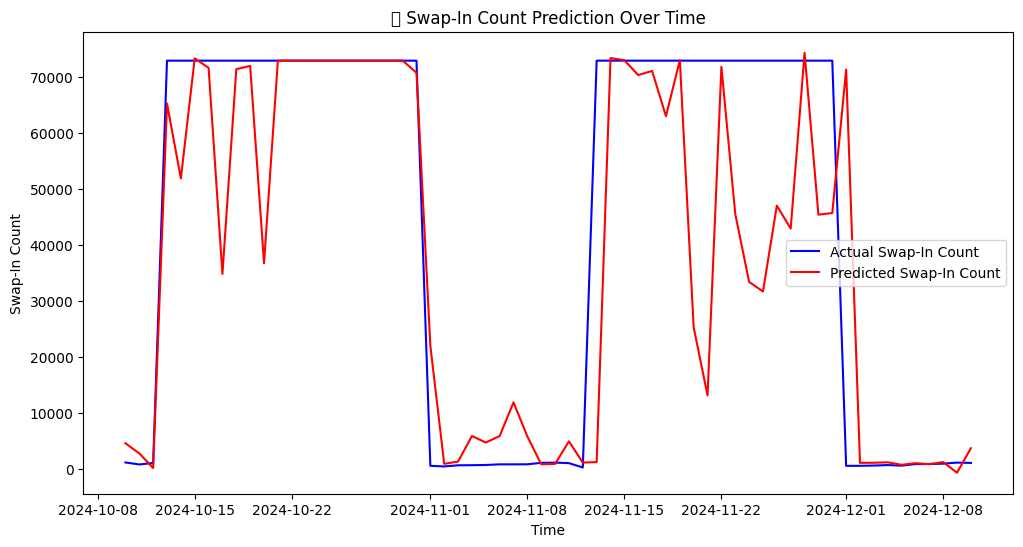

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(battery_data['_time'].iloc[-len(y_test_in):], y_test_in, label="Actual Swap-In Count", color="blue")
plt.plot(battery_data['_time'].iloc[-len(y_test_in):], y_pred_in, label="Predicted Swap-In Count", color="red")
plt.xlabel("Time")
plt.ylabel("Swap-In Count")
plt.title("📉 Swap-In Count Prediction Over Time")
plt.legend()
plt.show()

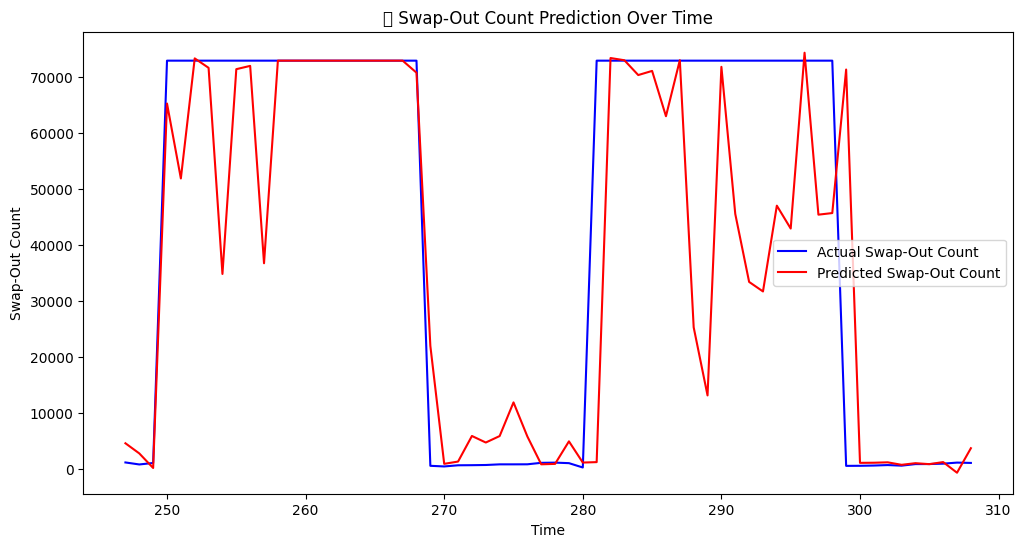

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_out.index, y_test_out, label="Actual Swap-Out Count", color="blue")
plt.plot(y_test_out.index, y_pred_out, label="Predicted Swap-Out Count", color="red")
plt.xlabel("Time")
plt.ylabel("Swap-Out Count")
plt.title("📉 Swap-Out Count Prediction Over Time")
plt.legend()
plt.show()

#Building LSTM Model

In [ ]:
# **Ensure Non-Zero Target Data Exists**
if battery_data[target_in].sum() > 0 and battery_data[target_out].sum() > 0:

    # **Normalize Features**
    scaler = MinMaxScaler()
    battery_data[features] = scaler.fit_transform(battery_data[features])

In [ ]:
# **Prepare Data for LSTM (Sequences of 7 Days)**
def create_sequences(df, target, sequence_length=7):
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(df[features].iloc[i:i + sequence_length].values)  # Select features for X
        # Access the original battery_data DataFrame to get the target values:
        y.append(battery_data[target].iloc[i + sequence_length])  # Select target for y
    return np.array(X), np.array(y)

In [ ]:
# **Create Sequences for Swap-In and Swap-Out**
X_in, y_in = create_sequences(battery_data[features], target_in)
X_out, y_out = create_sequences(battery_data[features], target_out)

In [ ]:
 # **Split Data into Train & Test Sets**
split = int(0.8 * len(X_in))
X_train_in, X_test_in, y_train_in, y_test_in = X_in[:split], X_in[split:], y_in[:split], y_in[split:]
X_train_out, X_test_out, y_train_out, y_test_out = X_out[:split], X_out[split:], y_out[:split], y_out[split:]


# 📌 Build LSTM Model for Time-Series Forecasting

### **Why Use LSTM?**
- **LSTM (Long Short-Term Memory)** is a type of recurrent neural network (RNN) designed for **time-series forecasting**.
- Unlike traditional models like XGBoost, LSTM can **capture temporal dependencies** and recognize long-term patterns in sequential data.

### **How the Model is Built**
1. **Input Layer (LSTM)**
   - `LSTM(50, return_sequences=True, input_shape=(X_train_in.shape[1], X_train_in.shape[2]))`
   - The first LSTM layer has **50 neurons** and `return_sequences=True`, meaning it passes outputs to the next LSTM layer.
   - `input_shape=(X_train_in.shape[1], X_train_in.shape[2])` sets the input size based on training data.

2. **Dropout Layer (0.2)**
   - `Dropout(0.2)` randomly drops 20% of neurons to **prevent overfitting**.

3. **Second LSTM Layer**
   - `LSTM(50, return_sequences=False)` – Another **50-neuron LSTM layer**, but this time it **does not return sequences**, meaning it outputs a single prediction.

4. **Dropout Layer (0.2)**
   - Another dropout layer to reduce **overfitting**.

5. **Fully Connected Dense Layers**
   - `Dense(25, activation='relu')` – A dense layer with **25 neurons** and **ReLU activation**, which helps learn non-linear relationships.
   - `Dense(1)` – The final layer outputs a **single value (swap-in or swap-out prediction)**.

6. **Compile the Model**
   - `model.compile(optimizer='adam', loss='mse')`
   - **Adam optimizer** is used for efficient training.
   - **Mean Squared Error (MSE)** is the loss function, ideal for regression tasks.
]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
# **Build LSTM Model**
def build_lstm_model():
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(X_train_in.shape[1], X_train_in.shape[2])),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

In [ ]:
 # **Train LSTM for Swap-In Prediction**
lstm_model_in = build_lstm_model()
lstm_model_in.fit(X_train_in, y_train_in, epochs=50, batch_size=16, validation_data=(X_test_in, y_test_in), verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 3849478656.0000 - val_loss: 3225167872.0000
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3985982720.0000 - val_loss: 3224812544.0000
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4162949376.0000 - val_loss: 3224014848.0000
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4071841024.0000 - val_loss: 3223455744.0000
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3787367936.0000 - val_loss: 3222904320.0000
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3856584192.0000 - val_loss: 3222288384.0000
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4045929984.0000 - val_loss: 3221573632.0000
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3736201472.0000 - val_loss: 3220797952.0000
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3945389056.0000 - val_loss: 3219940352.0000
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3588588544.0000 - val_lo

In [ ]:
# **Train LSTM for Swap-Out Prediction**
lstm_model_out = build_lstm_model()
lstm_model_out.fit(X_train_out, y_train_out, epochs=50, batch_size=16, validation_data=(X_test_out, y_test_out), verbose=1)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 3857291520.0000 - val_loss: 3225400064.0000
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3883693824.0000 - val_loss: 3225334528.0000
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3852948992.0000 - val_loss: 3225048320.0000
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4041635840.0000 - val_loss: 3224730624.0000
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4097866752.0000 - val_loss: 3224475392.0000
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3871345664.0000 - val_loss: 3224204800.0000
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4005473280.0000 - val_loss: 3223909120.0000
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3944554240.0000 - val_loss: 3223576832.0000
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3966278144.0000 - val_loss: 3223224320.0000
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3963544320.00

In [ ]:
 # **Make Predictions**
y_pred_in = lstm_model_in.predict(X_test_in)
y_pred_out = lstm_model_out.predict(X_test_out)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step


In [ ]:
 # **Evaluate Model Performance**
mae_in = mean_absolute_error(y_test_in, y_pred_in)
mse_in = mean_squared_error(y_test_in, y_pred_in)
rmse_in = np.sqrt(mse_in)

In [ ]:
mae_out = mean_absolute_error(y_test_out, y_pred_out)
mse_out = mean_squared_error(y_test_out, y_pred_out)
rmse_out = np.sqrt(mse_out)


In [ ]:
print(f"📊 LSTM Model Evaluation for Swap-In Count:\n MAE: {mae_in:.4f}\n MSE: {mse_in:.4f}\n RMSE: {rmse_in:.4f}")
print(f"📊 LSTM Model Evaluation for Swap-Out Count:\n MAE: {mae_out:.4f}\n MSE: {mse_out:.4f}\n RMSE: {rmse_out:.4f}")


📊 LSTM Model Evaluation for Swap-In Count:
 MAE: 43689.2458
 MSE: 3124099134.5540
 RMSE: 55893.6413
📊 LSTM Model Evaluation for Swap-Out Count:
 MAE: 44038.5050
 MSE: 3181425898.1773
 RMSE: 56404.1302


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


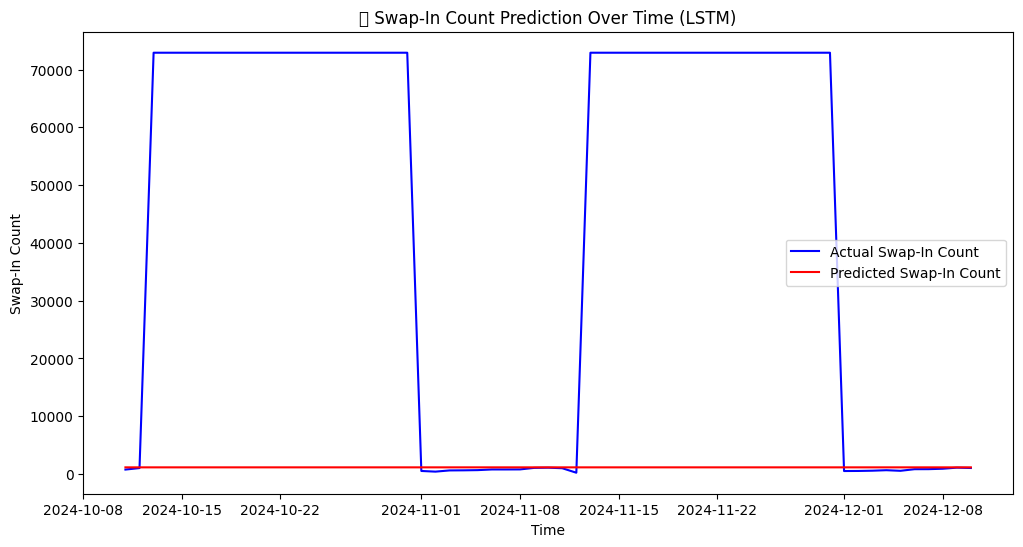

In [ ]:
# **Plot Actual vs Predicted Swap Counts**
# **Plot Actual vs Predicted Swap Counts**
plt.figure(figsize=(12, 6))
plt.plot(battery_data['_time'].iloc[-len(y_test_in):], y_test_in, label="Actual Swap-In Count", color="blue")
plt.plot(battery_data['_time'].iloc[-len(y_test_in):], y_pred_in, label="Predicted Swap-In Count", color="red")
plt.xlabel("Time")
plt.ylabel("Swap-In Count")
plt.title("📉 Swap-In Count Prediction Over Time (LSTM)")
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


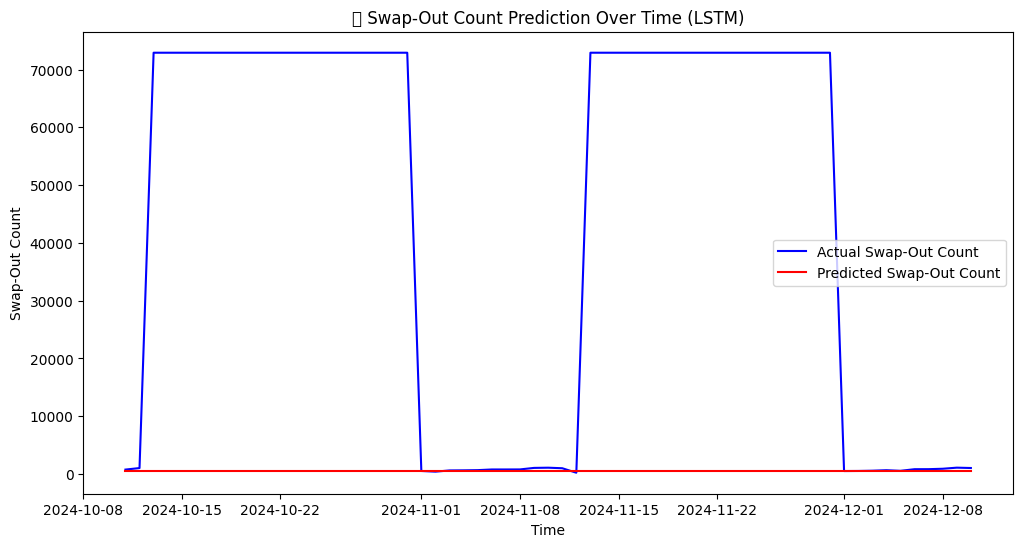

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(battery_data['_time'].iloc[-len(y_test_out):], y_test_out, label="Actual Swap-Out Count", color="blue")
plt.plot(battery_data['_time'].iloc[-len(y_test_out):], y_pred_out, label="Predicted Swap-Out Count", color="red")
plt.xlabel("Time")
plt.ylabel("Swap-Out Count")
plt.title("📉 Swap-Out Count Prediction Over Time (LSTM)")
plt.legend()
plt.show()